In [1]:
Data_path = "PLAID"
%ls $Data_path

 Volume in drive D has no label.
 Volume Serial Number is D8CA-E0D0

 Directory of D:\NILM\DataHandler\PLAID

22/08/2016  11:43    <DIR>          .
22/08/2016  11:43    <DIR>          ..
22/08/2016  11:16    <DIR>          CSV
22/08/2016  11:35           540ÿ023 meta1.json
               1 File(s)        540ÿ023 bytes
               3 Dir(s)   2ÿ121ÿ691ÿ136 bytes free


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

csv_path = Data_path + '\CSV'
csv_files = os.listdir(csv_path)

In [17]:
import subprocess

def read_data_given_id(path, ids, progress=False, last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i, ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+"\\"+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+"\\"+
                    str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                    names='current,voltage',dtype=(float,float))
        return data

In [4]:
import json
print(Data_path + "\meta1.json")
with open(Data_path + "\meta1.json") as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]

PLAID\meta1.json


In [5]:
meta1[0]

{u'id': u'1',
 u'meta': {u'appliance': {u'brand': u'',
   u'current': u'',
   u'manufacture_year': u'',
   u'model_number': u'',
   u'notes': u'',
   u'voltage': u'',
   u'wattage': u''},
  u'header': {u'collection_time': u'July, 2013',
   u'notes': u'some instances are not well calibrated, meta data are not complete',
   u'sampling_frequency': u'30000Hz'},
  u'instances': {u'length': u'2.00s', u'status': u'off-on'},
  u'location': u'house1',
  u'type': u'Compact Fluorescent Lamp'}}

In [6]:
def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M

In [7]:
Meta = parse_meta(meta)

In [8]:
Meta[1000]

{u'appliance': {u'brand': u'',
  u'current': u'',
  u'manufacture_year': u'',
  u'model_number': u'',
  u'notes': u'',
  u'voltage': u'',
  u'wattage': u''},
 u'header': {u'collection_time': u'July, 2013',
  u'notes': u'some instances are not well calibrated, meta data are not complete',
  u'sampling_frequency': u'30000Hz'},
 u'instances': {u'length': u'2.00s', u'status': u'off-on'},
 u'location': u'house51',
 u'type': u'Laptop'}

In [9]:
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
print(Unq_type)

# appliances
Apps = [x['meta']['type'] for x in meta1]

[u'Air Conditioner', u'Compact Fluorescent Lamp', u'Fan', u'Fridge', u'Hairdryer', u'Heater', u'Incandescent Light Bulb', u'Laptop', u'Microwave', u'Vacuum', u'Washing Machine']


In [10]:
print('number of total instances: %d' % len(Types))
print('number of unique appliances: %d' % len(Apps))
print('number of unique appliances: %d' % len(Unq_type))

number of total instances: 1074
number of unique appliances: 1074
number of unique appliances: 11


In [11]:
print('%25s\t%8s' % ('Appliance Type','# instances'))
for t in Unq_type:
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d' % (t,len(t_ids)))

           Appliance Type	# instances
          Air Conditioner	        66
 Compact Fluorescent Lamp	       175
                      Fan	       115
                   Fridge	        38
                Hairdryer	       156
                   Heater	        35
  Incandescent Light Bulb	       114
                   Laptop	       172
                Microwave	       139
                   Vacuum	        38
          Washing Machine	        26


In [19]:
# get 5 random instances from each type, will take ~ 1min to run
import random

count = 5
num_type = len(Unq_type)
fs = 30000

ids_to_draw = {}
t_data = {}
for (ii,t) in enumerate(Unq_type):
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    ids_to_draw[t] = random.sample(t_ids, count)
    t_data[t] = read_data_given_id(csv_path, ids_to_draw[t], False)

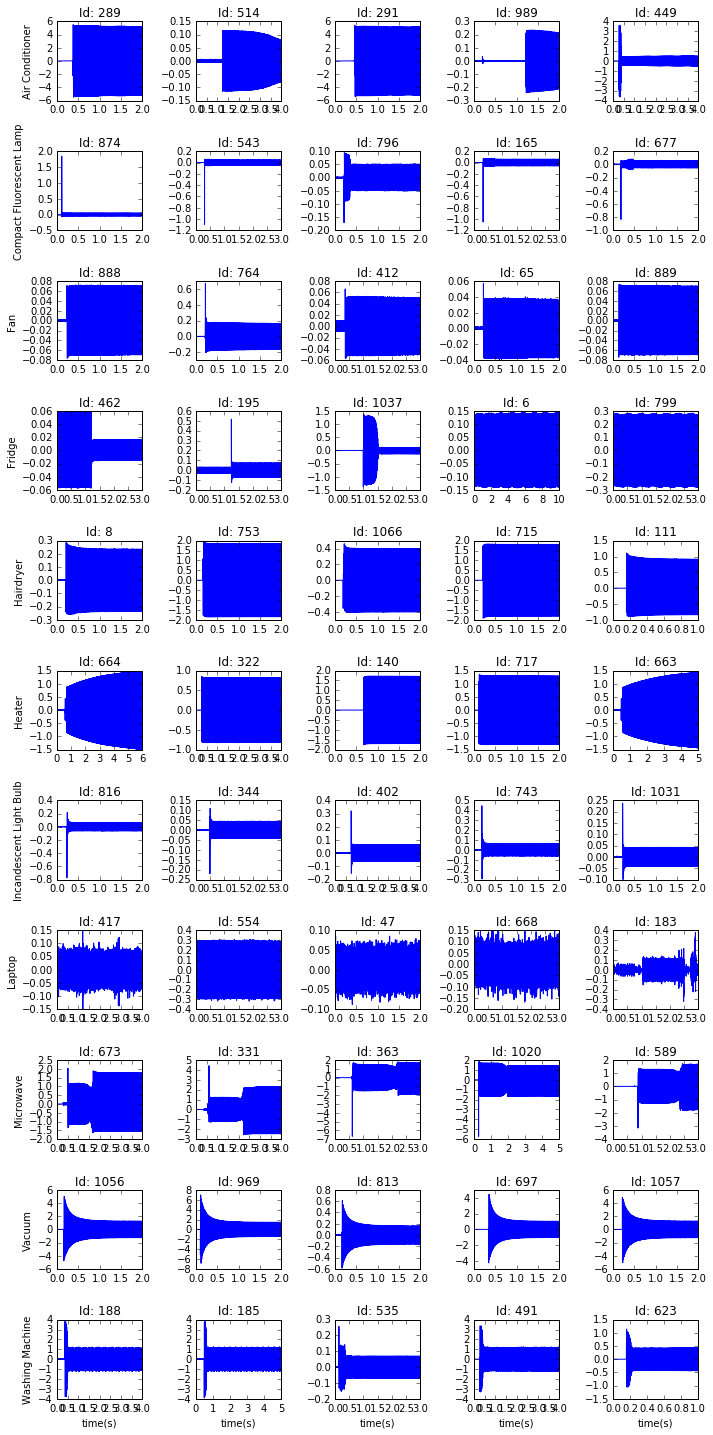

In [20]:
# plot current
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(np.linspace(1./fs,len(v['current'])/fs,num=len(v['current'])),v['current'])
        if ii==num_type-1:
            plt.xlabel('time(s)')
        if jj==0: 
            plt.ylabel(t,fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()

C:\Users\axelv\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


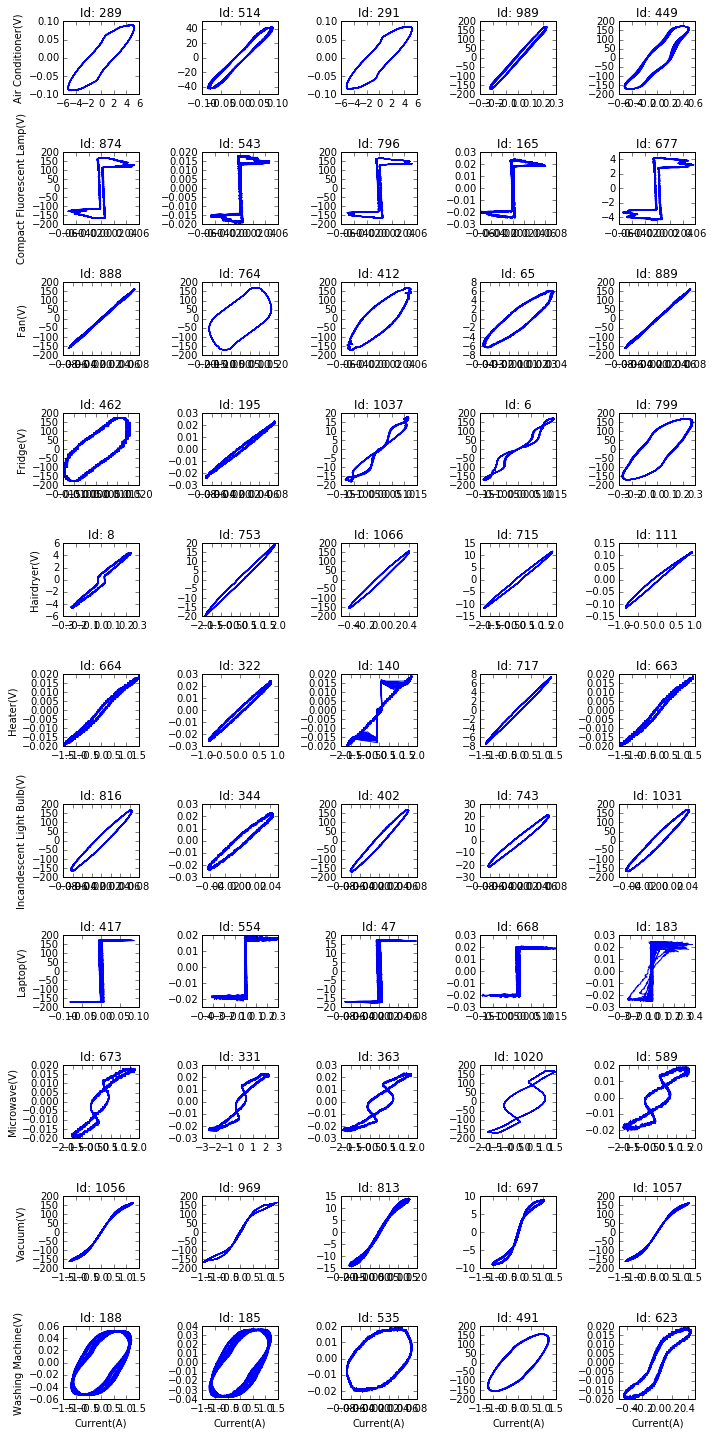

In [21]:
# plot V-I of last 10 steady state periods
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(v['current'][-1e4:],v['voltage'][-1e4:])
        if ii==num_type-1:
            plt.xlabel('Current(A)')
        if jj==0: 
            plt.ylabel(t+ '(V)',fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()